In [36]:
import numpy as np
import matplotlib.pyplot as plt
import math
import gurobipy as gp
from gurobipy import GRB
from itertools import permutations
from itertools import combinations
import random
from random import choice
import time
import copy
import pandas as pd
from scipy.stats import bernoulli

In [37]:
np.random.seed(1)
random.seed(1)

In [38]:
def collection_distribution_mnl(n,collection,v):
    
    collection_distribution = np.zeros((n,len(collection)))

    
    for i in range(len(collection)):
        curr_total_v = 0
        for j in range(len(collection[i])): 
            curr_total_v = curr_total_v + math.exp(v[collection[i][j]])
            #curr_total_v += v[collection[i][j]]
        #print('the '+str(i)+"th total v",curr_total_v)
        for k in range(len(collection[i])):
            collection_distribution[collection[i][k]][i] = math.exp(v[collection[i][k]])/curr_total_v
            #collection_distribution[collection[i][k]][i]= v[collection[i][k]]/curr_total_v

    return collection_distribution

In [39]:
def gaussian_noise(coll_distribution,std,alpha):
    
    idxs = np.dstack((np.nonzero(coll_distribution)[0],np.nonzero(coll_distribution)[1]))[0]
    temp = copy.deepcopy(coll_distribution)
    temp[temp>0]=1
    for idx in idxs:
        if np.random.random()>alpha:
            temp[idx[0]][idx[1]]=0
    noise = temp*np.random.normal(0,std,size=coll_distribution.shape)
    p_coll_distribution = coll_distribution +noise*coll_distribution
    ''' p_coll_distribution = coll_distribution +noise
    p_coll_distribution[p_coll_distribution<0]=math.pow(10,-6) '''
    p_coll_distribution = p_coll_distribution/p_coll_distribution.sum(axis=0)
    
    return p_coll_distribution

In [40]:
''' def mnl_feasiblity_check(data,collection,n):
    start_time = time.time()
    model = gp.Model('mnl')
    model.setParam('OutputFlag', 0)
    v = model.addVars(n,name = 'v') # positive 
    
    for ass_idx in range(len(collection)):
        for i in collection[ass_idx]:
            model.addConstr(data[i][ass_idx]*sum(v[j] for j in collection[ass_idx])-v[i]==0)
    
    
    model.addConstrs(v[i]>=0 for i in range(n))
    model.setObjective(0,GRB.MAXIMIZE)
    model.optimize()
    used_time = time.time()-start_time
    
    soln = []
    
    for v in model.getVars():
        soln.append(v.x)
    
    
    if model.Status == 2: #optimal
        #return [1,model.Runtime]
        if sum(soln)>0:
            return [1, used_time]
        if sum(soln)==0:  # the value of v cannot be all zero : recall that v here is actually exp(v) in MNL so ,all v should be positive
            return [0, used_time]
    
    if model.Status == 3: #infeasible
        #return [0,model.Runtime]
        return [0, used_time] '''

" def mnl_feasiblity_check(data,collection,n):\n    start_time = time.time()\n    model = gp.Model('mnl')\n    model.setParam('OutputFlag', 0)\n    v = model.addVars(n,name = 'v') # positive \n    \n    for ass_idx in range(len(collection)):\n        for i in collection[ass_idx]:\n            model.addConstr(data[i][ass_idx]*sum(v[j] for j in collection[ass_idx])-v[i]==0)\n    \n    \n    model.addConstrs(v[i]>=0 for i in range(n))\n    model.setObjective(0,GRB.MAXIMIZE)\n    model.optimize()\n    used_time = time.time()-start_time\n    \n    soln = []\n    \n    for v in model.getVars():\n        soln.append(v.x)\n    \n    \n    if model.Status == 2: #optimal\n        #return [1,model.Runtime]\n        if sum(soln)>0:\n            return [1, used_time]\n        if sum(soln)==0:  # the value of v cannot be all zero : recall that v here is actually exp(v) in MNL so ,all v should be positive\n            return [0, used_time]\n    \n    if model.Status == 3: #infeasible\n        #return

In [41]:
def mnl_feasiblity_check(data,collection,n):
    
    actual_prod = np.unique(np.nonzero(data)[0]).tolist()
    start_time = time.time()
    model = gp.Model('mnl')
    model.setParam('OutputFlag', 0)
    v = model.addVars(n,name = 'v') # positive 
  
    for ass_idx in range(len(collection)):
        for i in collection[ass_idx]:
            model.addConstr(data[i][ass_idx]*sum(v[j] for j in collection[ass_idx])-v[i]==0)
    
    model.addConstrs(v[i]>=0 for i in range(n))
    model.addConstrs(v[i]<=100 for i in range(n))
    #model.setObjective(0,GRB.MAXIMIZE)
    model.setObjective(sum(v[i] for i in actual_prod),GRB.MAXIMIZE)
    model.optimize()
    used_time = time.time()-start_time
    
    # write the model 
    ''' print('write the model')
    model.write("out.sol")
    model.write("model.lp")  '''
    
    ''' if model.Status == 2: #optimal
        soln = []
    
        for v in model.getVars():
            soln.append(v.x)
        #return [1,model.Runtime]
        if sum(soln)>0:
            return [1, used_time]
        if sum(soln)==0:  # the value of v cannot be all zero : recall that v here is actually exp(v) in MNL so ,all v should be positive
            return [0, used_time]
    
    if model.Status == 3: #infeasible
        #return [0,model.Runtime]
        return [0, used_time] '''
    
    if model.Status == 3: #infeasible
    #return [0,model.Runtime]
        return [0, used_time]
    
    if model.Status == 2: #optimal
        soln = []
    
        for v in model.getVars():
            soln.append(v.x)
        #return [1,model.Runtime]
        if sum(soln)==0:  # the value of v cannot be all zero : recall that v here is actually exp(v) in MNL so ,all v should be positive
            return [0, used_time]
        
        for i in actual_prod:
            if soln[i] == 0:
                return[0,used_time]
        return [1,used_time]

In [42]:
def mdm_feasibility(data,ranking,equal):
    n,m = data.shape
    # for each product, find the assortments it belongs to 
    #prod_occurance = np.transpose(np.nonzero(data[0])).shape[0]  # count the number of assortments within each product , the size of assortment is fixed, all combinations of the products are taken, so the number of assortment including each product is the same
    #ranking = np.argsort(data,axis=1)[:,-prod_occurance:] # probability increasing order # take the last 2 or 3(size) 
    ub = 100
    
    start_time = time.time()
    model = gp.Model('mdm')
    #model.setParam(gp.GRB.Param.TimeLimit, 60)
    model.setParam('OutputFlag', 0)
    eps = model.addVar(name='eps')
    lam = model.addVars(m,name = 'lam')
    
    
    model.addConstr(eps<=ub ) # just give an upper bound (+ve) for eps, o.w., the problem is unbounded
    
    #for i in range(ranking.shape[0]): # from each product 
    for i in range(len(ranking)): # from each product 
        for j in range(len(ranking[i])-1): # the ranking of assortment in product i 
            model.addConstr(lam[ranking[i][j]]- lam [ranking[i][j+1]] - eps >=0)
    
    for i in range(len(equal)):
        for j in range(len(equal[i])-1):
            model.addConstr(lam[equal[i][j]]-lam[equal[i][j+1]]==0)
    
    model.setObjective(eps,GRB.MAXIMIZE)
    model.optimize()
    used_time = time.time() - start_time
    
    # write the model 
    ''' print('write the model')
    model.write("out.sol")
    model.write("model.lp")  '''
    
    soln = []

    for v in model.getVars():
        soln.append(v.x)

    if (soln[0]>0):
        return [1, used_time]
        #return [1,model.Runtime]
    else:
        return [0, used_time]
        #return [0,model.Runtime]

uniformly generated random assortment

In [43]:
alpha = 0.25
n = 1000
collection_size = [100,200,300,400,500,600,700,800,900,1000]
instance_size = 1000
p = 0.005 #0.005assortment of average size 5
std = 0.01
all_collection = [[] for _ in range(len(collection_size))]

# construct 1000 samples of random assortment size collection of first collection size
for j in range(instance_size):
    collection = []
    while(len(collection)<collection_size[0]):
        S_var = bernoulli.rvs(p,size = n)
        if np.sum(S_var)>1:
            S = np.nonzero(S_var)[0].tolist()
            if S not in collection or len(collection)==0:
                collection.append(S)
    all_collection[0].append(collection)


for i in range(1,len(collection_size)):
    all_collection[i] = copy.deepcopy(all_collection[i-1])
    for j in range(instance_size):
        while(len(all_collection[i][j])<collection_size[i]):
            S_var = bernoulli.rvs(p,size = n)
            if np.sum(S_var)>1:
                S = np.nonzero(S_var)[0].tolist()
                #if S not in collection :
                if S not in all_collection[i][j] :
                    all_collection[i][j].append(S)

all_instance = []
#for collection in all_collection:
for i in range(len(collection_size)):
    collection_ins = []   
    for j in range(instance_size):
        v = np.random.normal(0,1,size=n) #standard normal
        curr_coll_mnl = collection_distribution_mnl(n,all_collection[i][j],v)
        #curr_coll_mnl = collection_distribution_mnl(n,collection,v)
        collection_ins.append(gaussian_noise(curr_coll_mnl,std,alpha))
    all_instance.append(collection_ins)
      
    

In [44]:
''' df = pd.DataFrame(all_instance[0][23])
df.to_csv('distribution_check/coll_size'+str(collection_size[i])+'p_size'+str(n)+'notuniform.csv') '''

" df = pd.DataFrame(all_instance[0][23])\ndf.to_csv('distribution_check/coll_size'+str(collection_size[i])+'p_size'+str(n)+'notuniform.csv') "

In [45]:
''' for i in range(len(all_instance)):
    for j in range(instance_size):
        df = pd.DataFrame(all_instance[i][j])
        df.to_csv('distribution_check/coll_size'+str(collection_size[i])+'p_size'+str(n)+'notuniform.csv') '''

" for i in range(len(all_instance)):\n    for j in range(instance_size):\n        df = pd.DataFrame(all_instance[i][j])\n        df.to_csv('distribution_check/coll_size'+str(collection_size[i])+'p_size'+str(n)+'notuniform.csv') "

In [46]:
mdm_runtime_min = []
mdm_runtime_max = []
mdm_runtime_mean = []
mdm_all_feasibility = []
mdm_feas_mean = []

mnl_runtime_min = []
mnl_runtime_max = []
mnl_runtime_mean = []
mnl_all_feasibility = []
mnl_feas_mean = []

for i in range(len(all_instance)): # instance of the same collection size i 
    mnl_feas = []
    mnl_runtime = []
    mdm_feas = []
    mdm_runtime = []
    for j in range(len(all_instance[i])): # under the same collection size, there are instances of the instance size
        
        # feasibility check for MNL
        mnl_result = mnl_feasiblity_check(all_instance[i][j],all_collection[i][j],n)
        mnl_feas.append(mnl_result[0])
        mnl_runtime.append(mnl_result[1])
        
        # feasibility check of MDM
        rank = []
        curr_instance = all_instance[i][j]  
        raw_rank = np.argsort(curr_instance,axis=1)  
        # the indexes of all the enties are in increasing order in each row (product)
        # note that this argsort admits equal cases with index in increasing order
        # eg.
        ''' x =np.array([[1,1,0],[0,0,0],[0,0,1]]) is also feasible for the system means  '''
        for k in range(curr_instance.shape[0]): # find all the assortments in each product
            for l in np.nonzero(curr_instance[k]): 
                if len(l)>1: 
                    rank.append(raw_rank[k][-len(l):]) # take the ranking of the nonzero entries
        # add the reverse order of the equal probabilities
        #print(type(curr_instance))
        equal = []
        for k in range(curr_instance.shape[0]):
            for l in np.unique(curr_instance[k]):
                if l == 0 or l==1:
                    continue
                idx = np.flipud(np.argwhere(curr_instance[k] == l))
                if len(idx)>1:
                    print('check',idx)
                    idx = idx.reshape(1,-1).squeeze(0)
                    equal.append(idx)
                    ''' print('check the corresponding k th row of the rank ',rank[k])
                    print('check the corresponding element',idx)
                    print('element check',np.isin(idx,rank[k])) '''
                    print(len(idx))
                    if (True in np.isin(idx,rank[k])):
                        if len(rank[k])==2: #only with 
                            rank.pop(k) # only with 1 pair of equal probabilities of the row. 
                        else:
                            for ii in idx[:-1]:
                                rank[k] = rank[k].delete(ii) # leaving only 1 idex of the eqaul probability in the rank 

        
        mdm_result = mdm_feasibility(all_instance[i][j],rank,equal)
        mdm_feas.append(mdm_result[0])
        mdm_runtime.append(mdm_result[1])
        
    mnl_test = pd.DataFrame({'feasibility':mnl_feas,'runtime':mnl_runtime})
    mnl_test.to_csv('results/mnl/mnl_p_size'+str(n)+'csize'+str(collection_size[i])+'alpha_'+str(alpha)+'.csv')
    mnl_all_feasibility.append(mnl_feas_mean)
    mnl_feas_mean.append(sum(mnl_feas)/instance_size)
    mnl_runtime = np.array(mnl_runtime)
    mnl_runtime_min.append(np.min(mnl_runtime))
    mnl_runtime_max.append(np.max(mnl_runtime))
    mnl_runtime_mean.append(np.mean(mnl_runtime))    
    
    mdm_test = pd.DataFrame({'feasibility':mdm_feas,'runtime':mdm_runtime})
    mdm_test.to_csv('results/mdm/mdm_p_size'+str(n)+'csize'+str(collection_size[i])+'alpha_'+str(alpha)+'.csv')
    mdm_all_feasibility.append(mdm_feas)
    mdm_feas_mean.append(sum(mdm_feas)/instance_size)
    mdm_runtime = np.array(mdm_runtime)
    mdm_runtime_min.append(np.min(mdm_runtime))
    mdm_runtime_max.append(np.max(mdm_runtime))
    mdm_runtime_mean.append(np.mean(mdm_runtime))
print('fix product size with nested collection structure and random assortments')   

fix product size with nested collection structure and random assortments


run time 

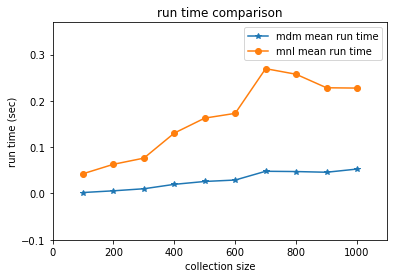

In [47]:
''' runtime '''
plt.plot(collection_size,mdm_runtime_mean,'*-',label = 'mdm mean run time')
plt.plot(collection_size,mnl_runtime_mean,'o-',label = 'mnl mean run time')
plt.xlim(collection_size[0]-100,collection_size[-1]+100)
plt.ylim(-0.1,max(np.max(np.array(mdm_runtime_mean)),np.max(np.array(mnl_runtime_mean)))+0.1)
plt.xlabel('collection size')
plt.ylabel('run time (sec)')
plt.legend()
plt.title('run time comparison')

''' for a, b in zip(collection_size, mdm_runtime_mean):
    plt.text(a, b, b, ha='center', va='bottom', fontsize=10)
    
for c, d in zip(collection_size, mnl_runtime_mean):
    plt.text(c, d, d, ha='center', va='bottom', fontsize=10) '''
    
plt.savefig('outputpic/runtime_p'+str(n)+'alpha_'+str(alpha)+'.png')
plt.savefig('outputpic/runtime_p'+str(n)+'alpha_'+str(alpha)+'.pdf')
plt.show()

representational power

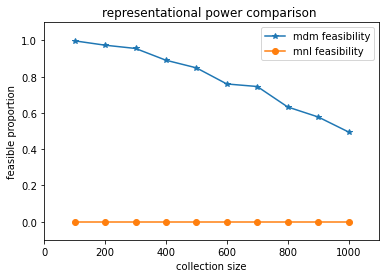

In [48]:
plt.plot(collection_size,mdm_feas_mean,'*-',label = 'mdm feasibility')
plt.plot(collection_size,mnl_feas_mean,'o-',label = 'mnl feasibility')
plt.xlim(collection_size[0]-100,collection_size[-1]+100)
plt.ylim(-0.1,1.1)
plt.xlabel('collection size')
plt.ylabel('feasible proportion')
plt.legend()
plt.title('representational power comparison ')

''' for a, b in zip(collection_size, mdm_feas_mean):
    plt.text(a, b, b, ha='left', va='bottom', fontsize=10,rotation=30)
    
for c, d in zip(collection_size, mnl_feas_mean):
    plt.text(c, d, d, ha='right', va='top',fontsize=10) '''

plt.savefig('outputpic/rep_power_p'+str(n)+'alpha_'+str(alpha)+'.png')
plt.savefig('outputpic/rep_power_p'+str(n)+'alpha_'+str(alpha)+'.pdf')
plt.show()

In [49]:
print(mnl_feas_mean)
mnl_test = pd.DataFrame({'collection':collection_size,'feasible percentage':mnl_feas_mean})
mnl_test.to_csv('summary/mnl/mnl_p_'+str(n)+'_std'+'alpha_'+str(alpha)+'.csv') 

[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


In [50]:
print(mdm_feas_mean)
mdm_test = pd.DataFrame({'collection':collection_size,'feasible percentage':mdm_feas_mean})
mdm_test.to_csv('summary/mdm/mdm_p_'+str(n)+'alpha_'+str(alpha)+'.csv') 

[0.998, 0.974, 0.956, 0.891, 0.849, 0.76, 0.746, 0.633, 0.578, 0.495]


In [51]:
summary = pd.DataFrame({'collection size':collection_size,'mdm feasibility':mdm_feas_mean,'mnl feasiblity':mnl_feas_mean,'mdm runtime':mdm_runtime_mean,'mnl runtime':mnl_runtime_mean})
summary.to_csv('summary/summary_mdm_mnl_alpha_'+str(alpha)+'.csv')

In [52]:
print('completed')

completed


In [56]:
prod_ind = np.nonzero(all_instance[0][0])[0].tolist()
assm_ind = np.nonzero(all_instance[0][0])[1].tolist()
len(prod_ind)

499

In [57]:
len(assm_ind)

499

In [59]:
df = pd.DataFrame({'product':prod_ind,'assortment':assm_ind})
df
df.to_csv('distribution_check/feasiblity.csv')

In [ ]:
''' df = pd.DataFrame(all_instance[0][23])
df.to_csv('distribution_check/coll_size'+str(collection_size[i])+'p_size'+str(n)+'notuniform.csv') '''